# Load Images

In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from google.cloud import storage
from google.oauth2 import service_account

In [3]:
def get_images_to_folder():
    
    #To change
    BUCKET_NAME = "youtube_optimizer_data" #Bucket name
    storage_dir = "bucket_data_short" #Folder in bucket that contains the images
    local_dir = "bucket_data_short/" #Create this manually in the same location as this file
    #Store the "massive-pen-365111-8eaed18fb748.json" file there as well

    my_credentials = service_account.Credentials.from_service_account_file("massive-pen-365111-8eaed18fb748.json")

    client = storage.Client(credentials=my_credentials)
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(storage_dir)
    
    blobs = bucket.list_blobs(prefix =storage_dir)
    for blob in blobs:
        filename = blob.name.replace('/','_')
        blob.download_to_filename(local_dir + filename)

In [4]:
get_images_to_folder()

In [5]:
#Specify the path to the folder in which you just stored the images
def load_images_from_folder(folder='/Users/nicolafriedrich/code/jacksharples1/youtube_optimizer/bucket_data_short'):
    images = []
    views = []
    video_ids = []
    for filename in os.listdir(folder):
        last_underscore = filename.rfind('_')
        video_id = filename[len('bucket_data_short'):last_underscore-1] #enter name of the folder in the bucket that contains the images
        if video_id not in video_ids:
            video_ids.append(video_id)
            if len(filename)< len('bucket_data_short')+1: #enter name of the folder in the bucket that contains the images
                continue
    
            else:
                img = plt.imread(os.path.join(folder,filename))
                if img.shape != (180,320,3):
                    continue
                else:
                    
                    y = int(filename[last_underscore +1:])
                    images.append(list(img))
                    views.append(y)
    return images, views


In [6]:
def dataloading():
    get_images_to_folder()
    X,y = load_images_from_folder()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = dataloading()

# Baseline model

In [38]:
from sklearn.metrics import mean_absolute_error

In [39]:
base_mae = np.mean(np.abs(y_train - np.mean(y_train)))

# Model

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import preprocess_input

2022-11-30 12:01:14.432655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def base_model():
    base_model = Xception(weights="imagenet",input_shape = (180,320,3),include_top=False)
    base_model.trainable = False
    return base_model

In [10]:
def complete_model():
    model = Sequential((
        base_model(),
        #GlobalAveragePooling2D(),
        AveragePooling2D(pool_size = (3,3)),
        Flatten(),
        Dense(50,activation = 'relu'),
        Dense(1,activation = 'linear')))
    
    opt = Adam(learning_rate=0.01, 
               beta_1=0.9, 
               beta_2=0.99)
    
    model.compile(loss="mae", optimizer='adam',
                  metrics=["mse"])
    
    return model  

In [11]:
model = complete_model()
model.summary()

2022-11-30 12:01:27.476210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 10, 2048)       20861480  
                                                                 
 average_pooling2d (AverageP  (None, 2, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 50)                614450    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 21,475,981
Trainable params: 614,501
Non-trainable params: 20,861,480
______________________________________

In [12]:
def preprocess(X_train, X_test):
    X_train = preprocess_input(X_train)
    X_test = preprocess_input(X_test)
    return X_train, X_test

In [13]:
X_train, X_test = preprocess(X_train,X_test)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 3, restore_best_weights = True)

In [15]:
history = model.fit(X_train,y_train, epochs = 1000,batch_size = 16,validation_split=0.2, callbacks = [es])

Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 10727.0088 - mse: 334696320.0000 - val_loss: 213352.5938 - val_mse: 45519327232.0000
Epoch 2/1000
1/1 [==============================] - 1s 697ms/step - loss: 10721.2227 - mse: 334549376.0000 - val_loss: 213348.0000 - val_mse: 45517369344.0000
Epoch 3/1000
1/1 [==============================] - 1s 694ms/step - loss: 10715.2783 - mse: 334396928.0000 - val_loss: 213343.1719 - val_mse: 45515309056.0000
Epoch 4/1000
1/1 [==============================] - 1s 702ms/step - loss: 10709.0439 - mse: 334236768.0000 - val_loss: 213338.2031 - val_mse: 45513187328.0000
Epoch 5/1000
1/1 [==============================] - 1s 678ms/step - loss: 10702.6367 - mse: 334071968.0000 - val_loss: 213333.1406 - val_mse: 45511028736.0000
Epoch 6/1000
1/1 [==============================] - 1s 679ms/step - loss: 10696.0967 - mse: 333903712.0000 - val_loss: 213327.9688 - val_mse: 45508820992.0000
Epoch 7/1000
1/1 [==============================]

1/1 [==============================] - 1s 738ms/step - loss: 10402.1299 - mse: 323939296.0000 - val_loss: 213123.5625 - val_mse: 45421654016.0000
Epoch 53/1000
1/1 [==============================] - 1s 708ms/step - loss: 10395.0293 - mse: 323643392.0000 - val_loss: 213118.1094 - val_mse: 45419327488.0000
Epoch 54/1000
1/1 [==============================] - 1s 719ms/step - loss: 10387.6797 - mse: 323346432.0000 - val_loss: 213112.8438 - val_mse: 45417082880.0000
Epoch 55/1000
1/1 [==============================] - 1s 702ms/step - loss: 10380.0908 - mse: 323048160.0000 - val_loss: 213107.7500 - val_mse: 45414912000.0000
Epoch 56/1000
1/1 [==============================] - 1s 697ms/step - loss: 10375.9072 - mse: 322748352.0000 - val_loss: 213103.3594 - val_mse: 45413040128.0000
Epoch 57/1000
1/1 [==============================] - 1s 709ms/step - loss: 10373.6387 - mse: 322460640.0000 - val_loss: 213099.5781 - val_mse: 45411430400.0000
Epoch 58/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 759ms/step - loss: 10163.3994 - mse: 309717408.0000 - val_loss: 212955.3594 - val_mse: 45349986304.0000
Epoch 104/1000
1/1 [==============================] - 1s 736ms/step - loss: 10157.1406 - mse: 309360960.0000 - val_loss: 212950.6094 - val_mse: 45347962880.0000
Epoch 105/1000
1/1 [==============================] - 1s 728ms/step - loss: 10150.7412 - mse: 308998752.0000 - val_loss: 212946.4688 - val_mse: 45346197504.0000
Epoch 106/1000
1/1 [==============================] - 1s 694ms/step - loss: 10144.6895 - mse: 308641952.0000 - val_loss: 212942.8594 - val_mse: 45344661504.0000
Epoch 107/1000
1/1 [==============================] - 1s 711ms/step - loss: 10138.1494 - mse: 308289728.0000 - val_loss: 212939.7344 - val_mse: 45343330304.0000
Epoch 108/1000
1/1 [==============================] - 1s 719ms/step - loss: 10131.9443 - mse: 307941344.0000 - val_loss: 212936.0156 - val_mse: 45341745152.0000
Epoch 109/1000
1/1 [=============================

1/1 [==============================] - 1s 795ms/step - loss: 9774.0010 - mse: 286553120.0000 - val_loss: 212681.2344 - val_mse: 45233307648.0000
Epoch 155/1000
1/1 [==============================] - 1s 792ms/step - loss: 9764.7109 - mse: 286007968.0000 - val_loss: 212673.9688 - val_mse: 45230215168.0000
Epoch 156/1000
1/1 [==============================] - 1s 757ms/step - loss: 9755.4795 - mse: 285444320.0000 - val_loss: 212667.5625 - val_mse: 45227491328.0000
Epoch 157/1000
1/1 [==============================] - 1s 712ms/step - loss: 9746.0332 - mse: 284890016.0000 - val_loss: 212661.0000 - val_mse: 45224701952.0000
Epoch 158/1000
1/1 [==============================] - 1s 716ms/step - loss: 9735.8652 - mse: 284317632.0000 - val_loss: 212655.2344 - val_mse: 45222248448.0000
Epoch 159/1000
1/1 [==============================] - 1s 725ms/step - loss: 9726.2041 - mse: 283754880.0000 - val_loss: 212648.7344 - val_mse: 45219483648.0000
Epoch 160/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 756ms/step - loss: 9201.2588 - mse: 253923248.0000 - val_loss: 212280.0781 - val_mse: 45062832128.0000
Epoch 206/1000
1/1 [==============================] - 1s 747ms/step - loss: 9188.3857 - mse: 253217200.0000 - val_loss: 212271.0312 - val_mse: 45058990080.0000
Epoch 207/1000
1/1 [==============================] - 1s 719ms/step - loss: 9175.0771 - mse: 252490928.0000 - val_loss: 212261.8438 - val_mse: 45055090688.0000
Epoch 208/1000
1/1 [==============================] - 1s 722ms/step - loss: 9161.5234 - mse: 251746432.0000 - val_loss: 212253.7344 - val_mse: 45051645952.0000
Epoch 209/1000
1/1 [==============================] - 1s 736ms/step - loss: 9148.9902 - mse: 251015568.0000 - val_loss: 212244.7656 - val_mse: 45047840768.0000
Epoch 210/1000
1/1 [==============================] - 1s 728ms/step - loss: 9136.0068 - mse: 250280832.0000 - val_loss: 212235.0000 - val_mse: 45043695616.0000
Epoch 211/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 934ms/step - loss: 8442.7354 - mse: 213710160.0000 - val_loss: 211750.6406 - val_mse: 44838334464.0000
Epoch 257/1000
1/1 [==============================] - 1s 1s/step - loss: 8426.2266 - mse: 212849664.0000 - val_loss: 211740.1094 - val_mse: 44833873920.0000
Epoch 258/1000
1/1 [==============================] - 1s 768ms/step - loss: 8408.5518 - mse: 212005120.0000 - val_loss: 211730.8125 - val_mse: 44829937664.0000
Epoch 259/1000
1/1 [==============================] - 1s 920ms/step - loss: 8393.0449 - mse: 211174736.0000 - val_loss: 211720.3906 - val_mse: 44825522176.0000
Epoch 260/1000
1/1 [==============================] - 1s 873ms/step - loss: 8376.5215 - mse: 210339856.0000 - val_loss: 211708.9375 - val_mse: 44820672512.0000
Epoch 261/1000
1/1 [==============================] - 1s 894ms/step - loss: 8358.7393 - mse: 209500784.0000 - val_loss: 211696.5469 - val_mse: 44815429632.0000
Epoch 262/1000
1/1 [==============================] - 1s 9

Epoch 308/1000
1/1 [==============================] - 1s 793ms/step - loss: 7478.3442 - mse: 167688352.0000 - val_loss: 211085.2969 - val_mse: 44557000704.0000
Epoch 309/1000
1/1 [==============================] - 1s 733ms/step - loss: 7458.0640 - mse: 166775264.0000 - val_loss: 211070.4219 - val_mse: 44550721536.0000
Epoch 310/1000
1/1 [==============================] - 1s 741ms/step - loss: 7438.0078 - mse: 165861264.0000 - val_loss: 211057.2031 - val_mse: 44545142784.0000
Epoch 311/1000
1/1 [==============================] - 1s 1s/step - loss: 7416.7969 - mse: 164963792.0000 - val_loss: 211045.5156 - val_mse: 44540211200.0000
Epoch 312/1000
1/1 [==============================] - 1s 1s/step - loss: 7396.7461 - mse: 164081184.0000 - val_loss: 211030.8281 - val_mse: 44534009856.0000
Epoch 313/1000
1/1 [==============================] - 1s 1s/step - loss: 7375.4888 - mse: 163160960.0000 - val_loss: 211013.4375 - val_mse: 44526669824.0000
Epoch 314/1000
1/1 [=============================

Epoch 360/1000
1/1 [==============================] - 1s 1s/step - loss: 6329.9858 - mse: 120095096.0000 - val_loss: 210291.5312 - val_mse: 44222529536.0000
Epoch 361/1000
1/1 [==============================] - 1s 1s/step - loss: 6303.0854 - mse: 119155240.0000 - val_loss: 210273.6094 - val_mse: 44214988800.0000
Epoch 362/1000
1/1 [==============================] - 1s 1s/step - loss: 6280.1855 - mse: 118236232.0000 - val_loss: 210257.7031 - val_mse: 44208300032.0000
Epoch 363/1000
1/1 [==============================] - 1s 1s/step - loss: 6255.6089 - mse: 117336032.0000 - val_loss: 210243.5781 - val_mse: 44202360832.0000
Epoch 364/1000
1/1 [==============================] - 1s 1s/step - loss: 6231.2461 - mse: 116452768.0000 - val_loss: 210226.0781 - val_mse: 44195004416.0000
Epoch 365/1000
1/1 [==============================] - 1s 1s/step - loss: 6206.6831 - mse: 115536256.0000 - val_loss: 210207.4531 - val_mse: 44187172864.0000
Epoch 366/1000
1/1 [==============================] - 1s 1

Epoch 412/1000
1/1 [==============================] - 1s 1s/step - loss: 4996.9849 - mse: 74763536.0000 - val_loss: 209370.6094 - val_mse: 43836051456.0000
Epoch 413/1000
1/1 [==============================] - 1s 1s/step - loss: 4967.9595 - mse: 73960344.0000 - val_loss: 209353.6719 - val_mse: 43828961280.0000
Epoch 414/1000
1/1 [==============================] - 1s 1s/step - loss: 4938.8530 - mse: 73144568.0000 - val_loss: 209338.6250 - val_mse: 43822661632.0000
Epoch 415/1000
1/1 [==============================] - 1s 1s/step - loss: 4913.5176 - mse: 72345824.0000 - val_loss: 209321.8750 - val_mse: 43815649280.0000
Epoch 416/1000
1/1 [==============================] - 1s 1s/step - loss: 4888.2515 - mse: 71547928.0000 - val_loss: 209301.4844 - val_mse: 43807113216.0000
Epoch 417/1000
1/1 [==============================] - 1s 1s/step - loss: 4859.6743 - mse: 70723800.0000 - val_loss: 209279.9844 - val_mse: 43798110208.0000
Epoch 418/1000
1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 1s 1s/step - loss: 3483.1643 - mse: 36347764.0000 - val_loss: 208334.6875 - val_mse: 43403341824.0000
Epoch 465/1000
1/1 [==============================] - 1s 1s/step - loss: 3453.7249 - mse: 35695420.0000 - val_loss: 208311.5000 - val_mse: 43393679360.0000
Epoch 466/1000
1/1 [==============================] - 1s 1s/step - loss: 3422.1260 - mse: 35048652.0000 - val_loss: 208287.0469 - val_mse: 43383492608.0000
Epoch 467/1000
1/1 [==============================] - 1s 1s/step - loss: 3390.4382 - mse: 34407476.0000 - val_loss: 208265.2500 - val_mse: 43374415872.0000
Epoch 468/1000
1/1 [==============================] - 1s 1s/step - loss: 3359.8552 - mse: 33782896.0000 - val_loss: 208245.8594 - val_mse: 43366338560.0000
Epoch 469/1000
1/1 [==============================] - 1s 1s/step - loss: 3327.2585 - mse: 33173426.0000 - val_loss: 208228.6406 - val_mse: 43359166464.0000
Epoch 470/1000
1/1 [==============================] - 1s 1s/step - loss: 3297.8

1/1 [==============================] - 1s 1s/step - loss: 1798.1124 - mse: 9657217.0000 - val_loss: 207175.2344 - val_mse: 42921578496.0000
Epoch 517/1000
1/1 [==============================] - 1s 1s/step - loss: 1764.0034 - mse: 9299996.0000 - val_loss: 207150.2344 - val_mse: 42911219712.0000
Epoch 518/1000
1/1 [==============================] - 1s 1s/step - loss: 1728.2806 - mse: 8936397.0000 - val_loss: 207125.3594 - val_mse: 42900914176.0000
Epoch 519/1000
1/1 [==============================] - 1s 1s/step - loss: 1691.5797 - mse: 8574561.0000 - val_loss: 207099.0000 - val_mse: 42889994240.0000
Epoch 520/1000
1/1 [==============================] - 1s 1s/step - loss: 1659.0446 - mse: 8220578.5000 - val_loss: 207075.5156 - val_mse: 42880270336.0000
Epoch 521/1000
1/1 [==============================] - 1s 1s/step - loss: 1624.5570 - mse: 7880174.5000 - val_loss: 207054.6094 - val_mse: 42871611392.0000
Epoch 522/1000
1/1 [==============================] - 1s 1s/step - loss: 1591.7448 - 

Epoch 569/1000
1/1 [==============================] - 1s 711ms/step - loss: 90.2714 - mse: 18466.9199 - val_loss: 205904.0625 - val_mse: 42396483584.0000
Epoch 570/1000
1/1 [==============================] - 1s 670ms/step - loss: 105.9549 - mse: 26510.1348 - val_loss: 205902.1875 - val_mse: 42395709440.0000
Epoch 571/1000
1/1 [==============================] - 1s 862ms/step - loss: 117.1635 - mse: 32605.7129 - val_loss: 205900.2344 - val_mse: 42394906624.0000
Epoch 572/1000
1/1 [==============================] - 1s 1s/step - loss: 125.5101 - mse: 36490.4492 - val_loss: 205898.2188 - val_mse: 42394075136.0000
Epoch 573/1000
1/1 [==============================] - 1s 1s/step - loss: 126.9481 - mse: 37929.0117 - val_loss: 205896.1406 - val_mse: 42393219072.0000
Epoch 574/1000
1/1 [==============================] - 1s 1s/step - loss: 122.1877 - mse: 37053.0234 - val_loss: 205894.0000 - val_mse: 42392338432.0000
Epoch 575/1000
1/1 [==============================] - 1s 1s/step - loss: 116.514

In [31]:
def plot_history(history, title='', axs=None, exp_name=""):
    plt.plot(history.history['loss'], label='train' + exp_name)
    plt.plot(history.history['val_loss'], label='val' + exp_name)
    plt.legend()

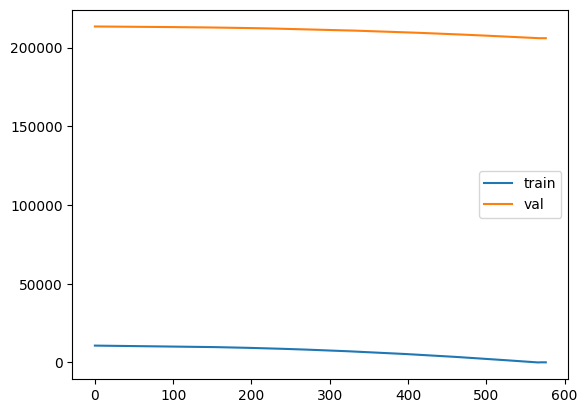

In [32]:
plot_history(history)

In [36]:
min(history.history['val_loss'])

205894.0

In [40]:
improvement = (base_mae - 2541534.7500)/base_mae
improvement

-32.44729803089375